# Imports and Global Variables

In [31]:
import os
os.chdir('/Users/gil2rok/school/crispr-phylogeny2/code/Heracles')

import pickle
import torch
import geoopt
import icecream as ic
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.linalg import expm, norm
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import average, to_tree
from icecream import install

from logalike import Logalike, my_dist
from util.misc_util import char_matrix_to_dist_matrix, embed_tree, embed_tree2, estimate_tree

In [32]:
%load_ext autoreload
%autoreload 2

sns.set_theme()
path = 'data' # relative path between parent directory (set above) to directory with saved data

install() # to install ice cream print statements everywhere called by this file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Running Model

In [33]:
# load true tree
fname = os.path.join(path, 'true_tree')
with open(fname, 'rb') as file:
    true_tree = pickle.load(file)
    
# load parameters for infinitesimal generator Q
fname = os.path.join(path, 'params')
with open(fname, 'rb') as file:
    params = pickle.load(file)
    
# TODO: fix path to call extract_compact_Q
# Q_compact = torch.tensor(extract_compact_Q(params['mutation_rate'], params['deletion_rate']))

In [34]:
def generate_Q(num_sites, num_states):
    
    deletion_rate = 9e-4 # global deletion rate 
    mutation_rate = [0.1] * num_sites # site-specific mutation rate
    indel_distribution = [1/num_states] * num_states
    
    Q = torch.zeros(num_sites + num_states + 1, num_sites + num_states + 1)

    for i in range(num_sites + num_states): # fill in diagonals
        if i < num_sites:
            Q[i,i] = - (mutation_rate[i] + deletion_rate)
        else:
            Q[i,i] = - deletion_rate
            
    for i in range(num_sites): # fill in upper right
        for j in range(num_states):
            Q[i, num_sites + j] = mutation_rate[i] * indel_distribution[j]
            
    for i in range(num_sites + num_states):
        Q[i, -1] = deletion_rate
        
    return Q

In [35]:
char_matrix = true_tree.character_matrix.drop_duplicates().to_numpy() # drop duplicate rows

num_cells = char_matrix.shape[0] # number of cells
num_sites = char_matrix.shape[1] # number of target sites
num_states = 15
embedding_dim = 3

Q_list = [generate_Q(num_sites, num_states) for _ in range(num_sites)]

rho = torch.tensor(2, dtype=torch.float64)

# initial guess for points
num_cells = char_matrix.shape[0]
manifold = geoopt.Lorentz(k=rho)

# X = manifold.random_normal(num_cells, embedding_dim, mean=2, std=15, dtype=torch.float64)

In [36]:
def manifold_dist(u, v):
    u = torch.tensor(u)
    v = torch.tensor(v)
    
    # dist = manifold.dist(u, v)
    dist = my_dist(u, v, rho) # TODO: delete
    return dist.detach().numpy()

def compute_error(X, dist_matrix):
    est_dist = squareform(pdist(X.detach().numpy(), metric=manifold_dist))
    diff = np.abs(est_dist - dist_matrix.detach().numpy())
    error = norm(diff, ord='fro')
    
    return error

In [46]:
dist_matrix = char_matrix_to_dist_matrix(char_matrix) # compute distance matrix
est_tree = estimate_tree(dist_matrix, method='neighbor-joining') # estimate of phylogenetic tree with UPGMA
X = embed_tree(est_tree, rho, num_cells, local_dim=embedding_dim-1) #TODO: figure out what local_dim is (embedding_dim-1?)
print(X)
X = embed_tree2(manifold, num_cells, embedding_dim)
print(X)

l = Logalike(X=X,
             priors=None,
             Q_list=Q_list,
             character_matrix=char_matrix,
             num_states=num_states,
             rho=rho,
            )

opt = geoopt.optim.RiemannianAdam(l.parameters(), lr=1e-1, maximize=False)
num_epochs = 10

loss_history, dist_error_history = [], []
for epoch in range(num_epochs):
    epoch_loss = 0
    for i in range(num_cells):
        print(i)
        opt.zero_grad() # zero gradient
        loss = -l.forward(i) # likelihood of tree configuration TODO: possibly negate
        loss.backward() # gradient on manifold
        opt.step() # take opt step
                
        epoch_loss += loss.item()
        
    loss_history.append(epoch_loss)
    dist_error_history.append(compute_error(l.X, dist_matrix))

tensor([[-0.8101, -0.0658,  2.1589],
        [ 0.6274,  0.4004,  2.1340],
        [ 2.3694, -1.0446,  3.2719],
        [-0.2028, -6.8435,  7.1326],
        [ 1.5043, -2.2648,  3.3753],
        [ 0.7371, -0.4363,  2.1757],
        [-0.7371,  0.4363,  2.1757],
        [ 0.7075, -0.2380,  2.1348],
        [ 0.0000,  0.0000,  2.0000]])
tensor([[ 1.4416,  0.0846,  0.2663],
        [ 1.5228, -0.2125, -0.5233],
        [ 1.7794,  1.0054, -0.3944],
        [ 1.5164, -0.5327,  0.1247],
        [ 1.4933,  0.4595, -0.1369],
        [ 1.5270, -0.0855, -0.5695],
        [ 1.7823, -0.7691,  0.7649],
        [ 1.4227,  0.0736, -0.1366],
        [ 1.7712,  0.2125, -1.0450]], dtype=torch.float64)
0


AssertionError: 

In [16]:
def minkowski_dot(x, y):
    # return -(x[0:1] @ y[0:1]) + (x[1:] @ y[1:]) # wikpedia convention
    return (x[:-1] @ y[:-1]) - (x[-1:] @ y[-1:]) # Wilson convention

a =  np.array([0.7546, 0.0074, 2.1376])
minkowski_dot(a, a)

-3.9998578399999998

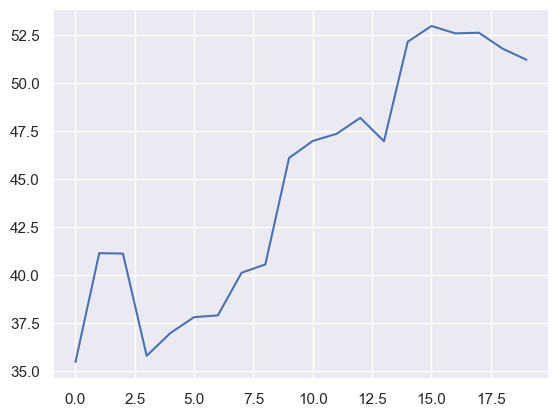

In [8]:
plt.plot(dist_error_history)

$d(u,v) =  \operatorname {arcosh}(-B(u,v))$ 

${\displaystyle \operatorname {arcosh} x=\ln \left(x+{\sqrt {x^{2}-1}}\right)}$ 

$B((x_0, x_1, \ldots, x_n), (y_0, y_1, \ldots, y_n)) = -x_0 y_0 + x_1 y_1 + \ldots + x_n y_n$